In [1]:
import numpy as np
import xarray as xr
import glob
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
outdir='/work/jet/data/interim/'

var = 'psi'
frq = 'annual'
nrho = 'hires'
dset = 'moc_rho2_online_%s'%nrho

In [3]:
ddict = {mod:{} for mod in ['CM4_c192_OM4p25','CM4_c192_OM4p125']}
ddict_exp = {exp:{} for exp in ['piControl_v7','piControl_v8','historical','ssp585']}

for i, mod in enumerate(ddict):
    for j, exp in enumerate(ddict_exp):
        
        if exp.split('_')[0]=='piControl':
            head = 'CM4_%s_c192_%s_%s'%(exp.split('_')[0],mod.split('_')[-1],exp.split('_')[1])
        else:
            head = 'CM4_%s_c192_%s'%(exp,mod.split('_')[-1])
            
        print(head)
        
        files = glob.glob(outdir+head+'_global_*_'+dset+'.nc')
        if len(files)>1:
            print('WARNING: More than one file for '+dset+' in '+head)
        elif len(files)==0:
            print('ERROR: No file available for '+dset+' in '+head)
            ddict_exp[exp] = []
            continue
            
        print('Loading '+files[0])
        da = xr.open_dataset(files[0])[var]
        
        if exp.split('_')[0]=='piControl':
            yr_st_cntr = 101
            yr_st_hist = 1850
            nyrs_shift = yr_st_hist-yr_st_cntr
            print('Shift time axis by',nyrs_shift,'years')
            da['time'] = da.time + timedelta(days=365*nyrs_shift)
        
        ddict_exp[exp] = da

    #print(mod)
    #ddict[mod] = ddict_exp
    ddict[mod] = ddict_exp.copy()

CM4_piControl_c192_OM4p25_v7
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p25_v7_global_0001to0350_moc_rho2_online_hires.nc
Shift time axis by 1749 years
CM4_piControl_c192_OM4p25_v8
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p25_v8_global_0101to0350_moc_rho2_online_hires.nc
Shift time axis by 1749 years
CM4_historical_c192_OM4p25
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_global_1850to2009_moc_rho2_online_hires.nc
CM4_ssp585_c192_OM4p25
Loading /work/jet/data/interim/CM4_ssp585_c192_OM4p25_global_2010to2099_moc_rho2_online_hires.nc
CM4_piControl_c192_OM4p125_v7
Loading /work/jet/data/interim/CM4_piControl_c192_OM4p125_v7_global_0001to0350_moc_rho2_online_hires.nc
Shift time axis by 1749 years
CM4_piControl_c192_OM4p125_v8
ERROR: No file available for moc_rho2_online_hires in CM4_piControl_c192_OM4p125_v8
CM4_historical_c192_OM4p125
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_global_1850to1939_moc_rho2_online_hires.nc
CM4_ssp585_c192_OM4p

In [4]:
tsdict = {mod:{} for mod in list(ddict.keys())}

for i, mod in enumerate(ddict):
    das = []
    tsdict[mod] = {exp:{} for exp in list(ddict[mod].keys())}
    
    for j, exp in enumerate(ddict[mod]):
        if len(ddict[mod][exp])==0:
            tsdict[mod][exp] = []
            continue
        print(mod,exp)
        
        da = ddict[mod][exp].sel(rho2_i=slice(1036.7,None),yq=slice(None,-55))
        da_dec = da.resample({'time':'10A'}).mean()
        da_dec['year'] = da_dec.time.dt.year-6
        da_dec = da_dec.swap_dims({'time':'year'})
        
        tsdict[mod][exp]['ann'] = da.min(dim=['rho2_i', 'yq']).groupby('time.year').mean('time')
        tsdict[mod][exp]['dec'] = da_dec.min(dim=['rho2_i', 'yq']).isel(year=slice(1,None))

CM4_c192_OM4p25 piControl_v7
CM4_c192_OM4p25 piControl_v8
CM4_c192_OM4p25 historical
CM4_c192_OM4p25 ssp585
CM4_c192_OM4p125 piControl_v7
CM4_c192_OM4p125 historical


In [5]:
ts = {name:{} for name in ['ann','dec']}

In [6]:
ts['ann']['p25'] = {name:{} for name in ['piControl','hist_ssp']}
ts['dec']['p25'] = {name:{} for name in ['piControl','hist_ssp']}

In [7]:
ts['ann']['p25']['piControl'] = xr.concat([tsdict['CM4_c192_OM4p25']['piControl_v7']['ann'].sel(year=slice(None, 1849)),
                                           tsdict['CM4_c192_OM4p25']['piControl_v8']['ann']], dim='year')
ts['dec']['p25']['piControl'] = xr.concat([tsdict['CM4_c192_OM4p25']['piControl_v7']['dec'].sel(year=slice(None, 1849)),
                                           tsdict['CM4_c192_OM4p25']['piControl_v8']['dec']], dim='year')

In [8]:
ts['ann']['p25']['hist_ssp'] = xr.concat([tsdict['CM4_c192_OM4p25']['historical']['ann'],
                                          tsdict['CM4_c192_OM4p25']['ssp585']['ann']], dim='year')
ts['dec']['p25']['hist_ssp'] = xr.concat([tsdict['CM4_c192_OM4p25']['historical']['dec'],
                                          tsdict['CM4_c192_OM4p25']['ssp585']['dec']], dim='year')

In [9]:
ts['ann']['p125'] = {name:{} for name in ['piControl','hist_ssp']}
ts['dec']['p125'] = {name:{} for name in ['piControl','hist_ssp']}

In [10]:
ts['ann']['p125']['piControl'] = tsdict['CM4_c192_OM4p125']['piControl_v7']['ann']
ts['dec']['p125']['piControl'] = tsdict['CM4_c192_OM4p125']['piControl_v7']['dec']

In [11]:
ts['ann']['p125']['hist_ssp'] = tsdict['CM4_c192_OM4p125']['historical']['ann']
ts['dec']['p125']['hist_ssp'] = tsdict['CM4_c192_OM4p125']['historical']['dec']

In [17]:
from mplsettings import setup_plots 

In [18]:
setup_plots()

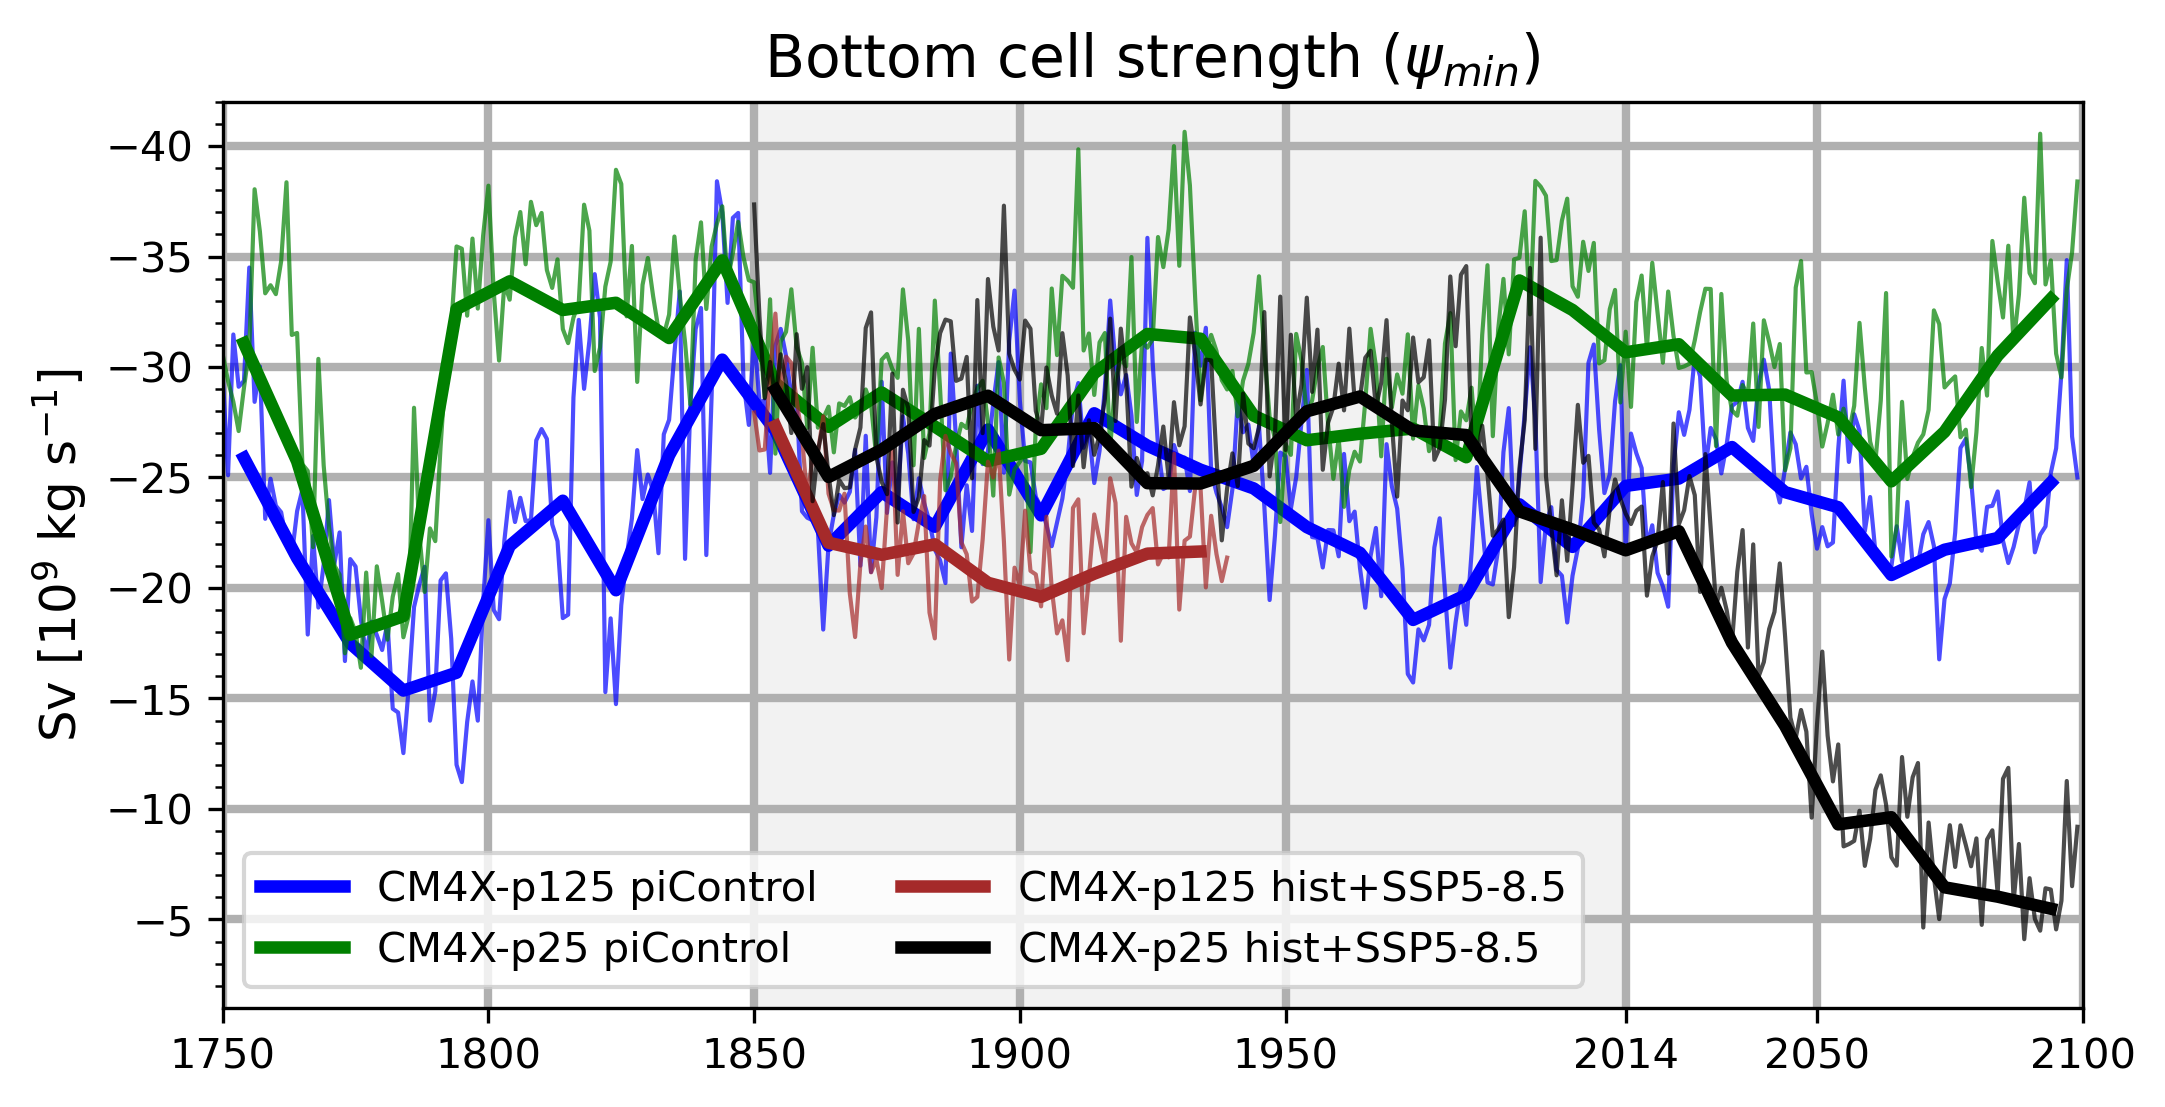

In [41]:
fig, ax = plt.subplots(figsize=(8,4))

ts['ann']['p125']['piControl'].plot(ax=ax,lw=1,c='b',alpha=0.7,_labels=False)
ts['dec']['p125']['piControl'].plot(ax=ax,lw=3,c='b',ls = '-',_labels=False,label='CM4X-p125 piControl')

ts['ann']['p25']['piControl'].plot(ax=ax,lw=1,c='g',alpha=0.7,_labels=False)
ts['dec']['p25']['piControl'].plot(ax=ax,lw=3,c='g',ls = '-',_labels=False,label='CM4X-p25 piControl')

ts['ann']['p125']['hist_ssp'].plot(ax=ax,lw=1,c='brown',alpha=0.7,_labels=False)
ts['dec']['p125']['hist_ssp'].plot(ax=ax,lw=3,c='brown',ls = '-',_labels=False,label='CM4X-p125 hist+SSP5-8.5')

ts['ann']['p25']['hist_ssp'].plot(ax=ax,lw=1,c='k',alpha=0.7,_labels=False)
ts['dec']['p25']['hist_ssp'].plot(ax=ax,lw=3,c='k',ls = '-',_labels=False,label='CM4X-p25 hist+SSP5-8.5')

ax.set_ylim([-42,-1])
ylimit = ax.get_ylim()
ax.fill([1850,2014,2014,1850],[ylimit[0]-1,ylimit[0]-1,ylimit[1]+0.2,ylimit[1]+0.2],'grey', alpha=0.1, edgecolor='None')

ax.set_yticks(np.arange(-40,0,5))
ax.set_yticks(np.arange(-42,-1,1),minor=True)
ax.invert_yaxis()

ax.set_xlim(1750,2100)
ax.set_xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])
ax.set_ylabel('Sv [10$^9$ kg s$^{-1}$]', fontsize=12)
#ax.set_xlabel('year')
ax.grid(linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.legend(frameon=True, fancybox=True, loc='lower left', ncol=2, fontsize=10)
ax.set_title('Bottom cell strength ($\psi_{min}$)', fontsize=14)
plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

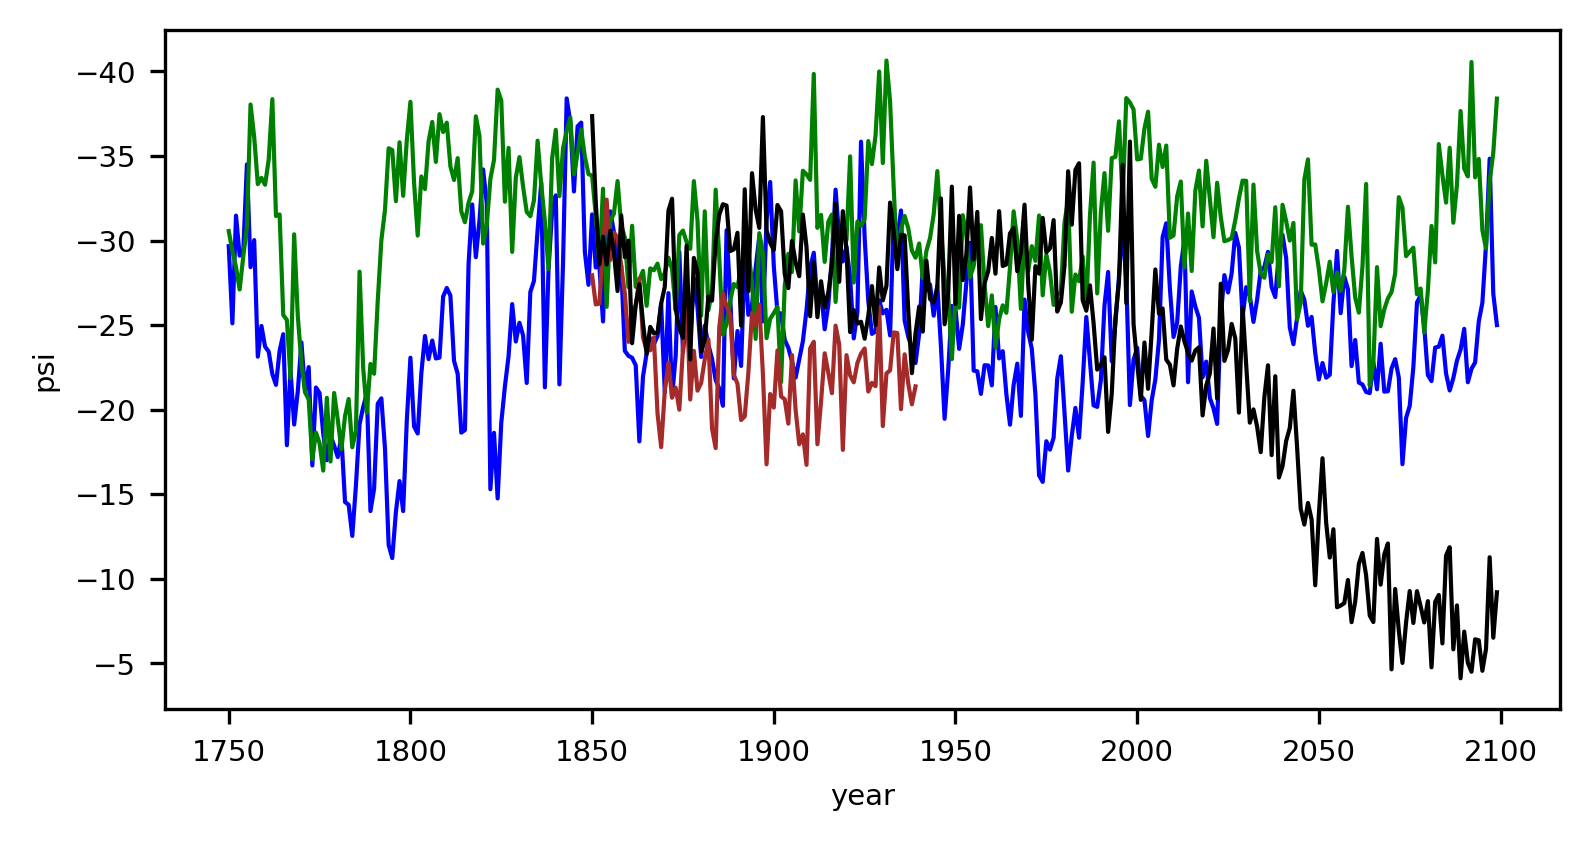

In [40]:
fig, ax = plt.subplots(figsize=(6,3))
ts['ann']['p125']['piControl'].plot(ax=ax,lw=1,c='b',label='CM4X-p125 piControl')
ts['ann']['p25']['piControl'].plot(ax=ax,lw=1,c='g',label='CM4X-p25 piControl')
ts['ann']['p125']['hist_ssp'].plot(ax=ax,lw=1,c='brown',label='CM4X-p125 hist+SSP5-8.5')
ts['ann']['p25']['hist_ssp'].plot(ax=ax,lw=1,c='k',label='CM4X-p25 hist+SSP5-8.5')
ax.invert_yaxis()
plt.show()